In [1]:
import json

import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
import torch_geometric.utils as utils
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn import GCNConv
from torch_geometric.nn import GATv2Conv
from torch_geometric.nn import GINConv
from sklearn.model_selection import train_test_split
import torch_geometric as tg
import numpy as np
from scipy.sparse import csr_matrix
from scipy import sparse as sp
import numpy as np
import networkx as nx
import sys
import random

In [2]:
def calculatePosEncodings(edge_index, num_nodes):
    edge_index = edge_index.t().tolist()
    edges = [(src, dst) for src, dst in edge_index]

# Create the adjacency matrix in CSR format -> das wird dann für die encodings benutzt!
    rows, cols = zip(*edges)
    data = np.ones(len(rows))
    A = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))

    ''' this code computes the in_degrees matrix from the edge list. it can later be adapted to compute the in-degrees matrix from the adjacency matrix (however, then, we should
    do some tests with small sample graphs to ensure everything is correct
    '''
    in_degrees_dict = {node: 0 for node in range(num_nodes)}
    # Calculate the in-degrees for each node
    for edge in edges:
        _, dst = edge
        in_degrees_dict[dst] += 1

    in_degrees = np.array([in_degrees_dict[i] for i in range(len(in_degrees_dict))], dtype=float)
    in_degrees = in_degrees.clip(1)  # Clip to ensure no division by zero
    in_degrees = np.power(in_degrees, -0.5)  # Take the element-wise inverse square root

    # Create the sparse diagonal matrix N
    N = sp.diags(in_degrees, dtype=float)

    L = sp.eye(num_nodes) - N * A * N

    #calc eigvals and eigVecs, equivalent to the original code
    EigVal, EigVec = np.linalg.eig(L.toarray())
    idx = EigVal.argsort() # increasing order
    EigVal, EigVec = EigVal[idx], np.real(EigVec[:,idx])

    #pos_enc_dim = hyperparameter!
    pos_enc_dim = 5
    RESULT_POS_ENCODING = torch.from_numpy(EigVec[:,1:pos_enc_dim+1]).float() 
    return RESULT_POS_ENCODING

def calculateLoss(task_loss, batch, num_nodes, positional_encoding):
    #HYPERPARAMETERS
    device = "cpu"
    pos_enc_dim = 1
    alpha_loss: 1e-3
    lambda_loss: 100  # ist auch 100

    #edge_index im korrekten Format definieren
    edge_index = batch.edge_index.t().tolist()
    edge_index = [(src, dst) for src, dst in edge_index]

    # Loss B: Laplacian Eigenvector Loss --------------------------------------------
    n = num_nodes

    # Laplacian 
    rows, cols = zip(*edge_index)
    data = np.ones(len(rows))
    A = csr_matrix((data, (rows, cols)), shape=(num_nodes, num_nodes))

    ''' this code computes the in_degrees matrix from the edge list. it can later be adapted to compute the in-degrees matrix from the adjacency matrix (however, then, we should
    do some tests with small sample graphs to ensure everything is correct'''

    in_degrees_dict = {node: 0 for node in range(num_nodes)}
    # Calculate the in-degrees for each node
    for edge in edge_index:
        _, dst = edge
        in_degrees_dict[dst] += 1

    in_degrees = np.array([in_degrees_dict[i] for i in range(len(in_degrees_dict))], dtype=float)
    in_degrees = in_degrees.clip(1)  # Clip to ensure no division by zero
    in_degrees = np.power(in_degrees, -0.5)  # Take the element-wise inverse square root

    # Create the sparse diagonal matrix N
    N = sp.diags(in_degrees, dtype=float)
    L = sp.eye(num_nodes) - N * A * N

    p = positional_encoding
    pT = torch.transpose(p, 1, 0)
    loss_b_1 = torch.trace(torch.mm(torch.mm(pT, torch.Tensor(L.todense()).to(device)), p))

    '''  TODO: loss_b_2 
    '''

    loss_b = loss_b_1

    #TODO: parameter tunen!
    loss = task_loss + 1e-3* loss_b
    return loss


def precision(predictions, targets, threshold):
    # Apply a threshold to the predictions
    binary_predictions = (predictions >= threshold).astype(int)
    binary_targets = (targets >= threshold).astype(int)

    # Calculate the true positive (TP) and false positive (FP) counts
    TP = np.sum((binary_predictions == 1) & (binary_targets == 1))
    FP = np.sum((binary_predictions == 1) & (binary_targets == 0))

    print("Negative: ")
    print(np.sum(binary_targets == 1))
    print("Positive: ")
    print(np.sum(binary_targets == 0))
    # Calculate precision
    precision_value = TP / (TP + FP)
    return precision_value

def recall(predictions, targets, threshold):
    # Apply a threshold to the predictions
    binary_predictions = (predictions >= threshold).astype(int)
    binary_targets = (targets >= threshold).astype(int)
    # Calculate the true positive (TP) and false negative (FN) counts
    TP = np.sum((binary_predictions == 1) & (binary_targets == 1))
    FN = np.sum((binary_predictions == 0) & (binary_targets == 1))
    # Calculate recall
    recall_value = TP / (TP + FN)
    return recall_value

In [3]:
# Reading in all the data

business_ids=[]
business_average_stars=[]
business_review_count=[]

try:
    with open('yelp_dataset/yelp_academic_dataset_business.json', 'r', encoding='utf-8') as json_file:
        for line in json_file:
            try:
                data = json.loads(line)
                business_ids.append(data["business_id"])
                business_average_stars.append(data["stars"])
                business_review_count.append(data["review_count"])
            except json.decoder.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print("File not found.")
print("done business")

review_ids=[]
review_business_ids=[]
review_user_ids=[]
review_stars=[]

try:
    with open('yelp_dataset/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as json_file:
        for i,line in enumerate(json_file):
            try:
                data = json.loads(line)
                review_ids.append(data["review_id"])
                review_business_ids.append(data["business_id"])
                review_user_ids.append(data["user_id"])
                review_stars.append(data["stars"])
            except json.decoder.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print("File not found.")
print("done reviews")

user_ids=[]

try:
    with open('yelp_dataset/yelp_academic_dataset_user.json', 'r', encoding='utf-8') as json_file:
        for line in json_file:
            try:
                data = json.loads(line)
                user_ids.append(data["user_id"])
            except json.decoder.JSONDecodeError as e:
                print(f"Error decoding JSON: {e}")
except FileNotFoundError:
    print("File not found.")
print("done users")

done business
done reviews
done users


In [4]:
# As there is too much data use a subset by manipulating the business and user sets

print(len(user_ids))
print(len(business_ids))
print(len(review_stars))

businesses = 10000
users = 20000

business_average_stars = business_average_stars[:businesses]
business_review_count = business_review_count[:businesses]
business_ids = business_ids[:businesses]

user_ids = user_ids[:users]

print("---------------------------------------------")
print(len(user_ids))
print(len(business_ids))
print(len(review_stars))

1987897
150346
6990280
---------------------------------------------
20000
10000
6990280


In [5]:
# User and business to index mapping in order.
# Review lists are adjusted to only include users and businesses from the subset lists.

user_to_index = {user_id: index for index, user_id in enumerate(user_ids)}
business_to_index = {business_id: index for index, business_id in enumerate(business_ids)}


user_index_col = [user_to_index[user_id] for user_id in user_ids]
business_index_col = [business_to_index[business_id] for business_id in business_ids]

skip_indexes = []
current_index = -1

for user_id in review_user_ids:
    try:
        current_index = current_index + 1
        tmp = user_to_index[user_id]
    except KeyError:
        skip_indexes.append(current_index)

current_index = -1
for business_id in review_business_ids:
    try:
        current_index = current_index + 1
        tmp = business_to_index[business_id]
    except KeyError:
        skip_indexes.append(current_index)    

skip_indexes = set(skip_indexes)
print(6990280 - len(skip_indexes))

47703


In [6]:
current_index = -1

review_user_index_col = []
for user_id in review_user_ids:
    try:
        current_index = current_index + 1
        if current_index in skip_indexes:
            pass
        else:
            user_index = user_to_index[user_id]
            review_user_index_col.append(businesses+user_index)
    except KeyError:
        print("Huh?")        
        
current_index = -1        
review_business_index_col = []
for business_id in review_business_ids:
    try:
        current_index = current_index + 1
        if current_index in skip_indexes:
            pass
        else:
            business_index = business_to_index[business_id]
            review_business_index_col.append(business_index)
    except KeyError:
        print("Huh?")
    
current_index = -1
adjusted_review_stars = []
for star in review_stars:
        current_index = current_index + 1
        if current_index in skip_indexes:
            pass
        else:
            adjusted_review_stars.append(star)
num_nodes = len(set(review_user_index_col)) + len(set(review_business_index_col))
print("Number of Users in index col " + str(len(set(review_user_index_col))))
print("Number of businesses in index col " + str(len(set(review_business_index_col))))
print("Total reviews left " + str(len(adjusted_review_stars)))
print(num_nodes)

Number of Users in index col 16327
Number of businesses in index col 6076
Total reviews left 47703
22403


In [7]:
# Feature list including average stars and the review_count/max_review_count of a business.
# Also a dummy padding is added for the users.

adjusted_features = []

for starts in business_average_stars:
    adjusted_features.append([starts])
    
highest_review_count = 0
for review in business_review_count:
    if(review > highest_review_count):
        highest_review_count = review
print(highest_review_count)
        
for i in range(len(business_review_count)):
    adjusted_features[i].append(business_review_count[i]/highest_review_count)

for i in range(len(business_review_count)):
    adjusted_features[i].append(random.randint(1, 10))    
    
adjusted_features_tensor = torch.tensor(adjusted_features)

num_features = len(adjusted_features[0])

num_users = len(set(user_ids))
user_genre_features = torch.zeros(num_users,num_features)

features = torch.cat((adjusted_features_tensor, user_genre_features), dim=0)

print(features)

4554
tensor([[5.0000e+00, 1.5371e-03, 1.0000e+01],
        [3.0000e+00, 3.2938e-03, 3.0000e+00],
        [3.5000e+00, 4.8309e-03, 5.0000e+00],
        ...,
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00]])


In [17]:
adjusted_review_stars_ud = adjusted_review_stars + adjusted_review_stars

rating_tensor = torch.tensor(adjusted_review_stars_ud, dtype=torch.float)

review_user_index_col_ud = review_user_index_col + review_business_index_col
review_business_index_col_ud = review_business_index_col + review_user_index_col



print(review_user_index_col_ud[0])
print(review_business_index_col_ud[0])

edge_index = torch.tensor([review_user_index_col_ud, review_business_index_col_ud], dtype=torch.long)

# positional_encodings = calculatePosEncodings(edge_index, num_nodes)

data = Data(edge_index=edge_index, x=features, y=rating_tensor, num_nodes=num_nodes)

print(edge_index)

11029
5077
tensor([[11029, 23302, 24726,  ...,   857,  5210,  2814],
        [ 5077,  4913,  6282,  ..., 14054, 22708, 12926]])


In [18]:
indices = list(range(data.edge_index.size(1)))

#das hier klein, damit der Speicher nicht überdreht wird. Aber nicht zu klein, weil sonst kommt es zu problemen!
train_indices, test_indices = train_test_split(indices, train_size=0.1, test_size=0.2)
train_indices, val_indices = train_test_split(train_indices, train_size=0.8, test_size=0.2, random_state=42)


#irgendeine syntax
train_data = data.__class__()
test_data = data.__class__()
val_data = data.__class__()


#setzt die Parameter von train_data und test_data

#soweit ich es verstehe, sind alle 2.500 nodes im training und testset vorhanden. gesplittet werden nur die edges, d.h. 
#es ist nur ein subset der 100.000 edges im training set sowie im test set vorhanden
# also 10% der Bewertungen 
train_data.edge_index = data.edge_index[:, train_indices]
train_data.y = data.y[train_indices]
train_data.num_nodes = data.num_nodes
train_data.x = data.x


test_data.edge_index = data.edge_index[:, test_indices]
test_data.y = data.y[test_indices]
test_data.num_nodes = data.num_nodes
test_data.x = data.x


val_data.edge_index = data.edge_index[:, val_indices]
val_data.y = data.y[val_indices]
val_data.num_nodes = data.num_nodes
val_data.x = data.x

print(data)
print(train_data)
print(test_data)
print(val_data)

Data(x=[30000, 3], edge_index=[2, 95406], y=[95406], num_nodes=22403)
Data(edge_index=[2, 7632], y=[7632], num_nodes=22403, x=[30000, 3])
Data(edge_index=[2, 19082], y=[19082], num_nodes=22403, x=[30000, 3])
Data(edge_index=[2, 1908], y=[1908], num_nodes=22403, x=[30000, 3])


Epoch 1/200, Training Loss: 12.782530784606934, Validation Loss: 6.849965572357178
Epoch 2/200, Training Loss: 6.183426380157471, Validation Loss: 9.359495162963867
Epoch 3/200, Training Loss: 16.047542572021484, Validation Loss: 5.3047261238098145
Epoch 4/200, Training Loss: 6.397059440612793, Validation Loss: 5.579812049865723
Epoch 5/200, Training Loss: 5.405509948730469, Validation Loss: 6.432802677154541
Epoch 6/200, Training Loss: 5.766853332519531, Validation Loss: 7.050166606903076
Epoch 7/200, Training Loss: 6.267515659332275, Validation Loss: 7.17238187789917
Epoch 8/200, Training Loss: 6.395277500152588, Validation Loss: 6.839328289031982
Epoch 9/200, Training Loss: 6.10513973236084, Validation Loss: 6.1763739585876465
Epoch 10/200, Training Loss: 5.519957542419434, Validation Loss: 5.339544773101807
Epoch 11/200, Training Loss: 4.831634044647217, Validation Loss: 4.513313293457031
Epoch 12/200, Training Loss: 4.273665428161621, Validation Loss: 3.882631301879883
Epoch 13/20

Epoch 99/200, Training Loss: 1.2715710401535034, Validation Loss: 1.304063081741333
Epoch 100/200, Training Loss: 1.2714214324951172, Validation Loss: 1.303984522819519
Epoch 101/200, Training Loss: 1.2712833881378174, Validation Loss: 1.3039344549179077
Epoch 102/200, Training Loss: 1.2711554765701294, Validation Loss: 1.3039079904556274
Epoch 103/200, Training Loss: 1.2710360288619995, Validation Loss: 1.3039008378982544
Epoch 104/200, Training Loss: 1.270923376083374, Validation Loss: 1.303907871246338
Epoch 105/200, Training Loss: 1.270815372467041, Validation Loss: 1.3039246797561646
Epoch 106/200, Training Loss: 1.2707107067108154, Validation Loss: 1.3039369583129883
Epoch 107/200, Training Loss: 1.2706005573272705, Validation Loss: 1.303966760635376
Epoch 108/200, Training Loss: 1.270497441291809, Validation Loss: 1.3040088415145874
Epoch 109/200, Training Loss: 1.270400881767273, Validation Loss: 1.304057240486145
Epoch 110/200, Training Loss: 1.2703114748001099, Validation Los

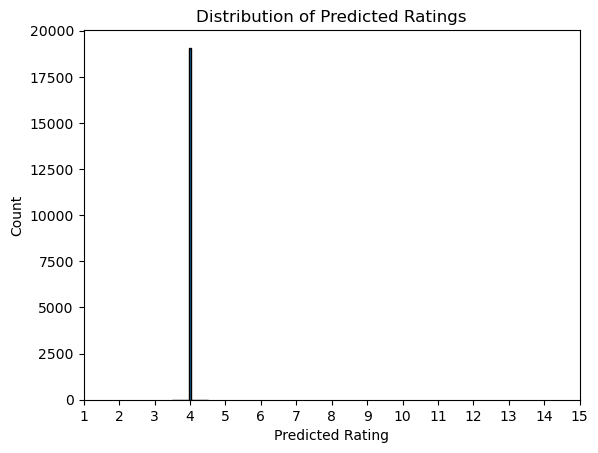

In [21]:

'''
das ist jetzt ohne die forward function!

PROBLEM: node features und positional weglassen ändert nix! Das ist im Moment leider quatsch, neuer versuch...
DH WIR BRAUCHEN EIN GCN, dem wir node features und edge features geben, irgendwie so...vielleicht mal mit Tutor besprechen, ich blicke überhaupt nicht durch mittlerweile

'''
'''

class GCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(GCN, self).__init__()

        #hardcode: 1 edge feature
        self.conv1_edge = GCNConv(1, hidden_channels)
        self.conv2_edge = GCNConv(hidden_channels, num_classes)

        #hardcode: 19 node features
        self.conv1_node = GCNConv(19, hidden_channels)
        self.conv2_node = GCNConv(hidden_channels, num_classes)

        #hardcode: number of dimensions of pos encodings
        self.conv1_pos = GCNConv(5, hidden_channels)
        self.conv2_pos = GCNConv(hidden_channels, num_classes)

        

    def forward(self, node_features, edge_index, pos_embeddings):
        #learn the edge features
        target_feature_OUT = self.conv1_edge(torch.ones((edge_index.size(1), 1), device=edge_index.device), edge_index)
        target_feature_OUT = F.relu(target_feature_OUT)
        target_feature_OUT = self.conv2_edge(target_feature_OUT, edge_index)       

        
        #learn the node features
        node_features_init = node_features.view(-1, node_features.size(2))
        node_x = self.conv1_node(node_features_init, edge_index)
        node_x = F.relu(node_x)
        node_x = self.conv2_node(node_x, edge_index)    

        #learn the positional embeddings
        pos_embeddings_init = pos_embeddings.view(-1, pos_embeddings.size(2))
        pos_embeddings = self.conv1_pos(pos_embeddings_init, edge_index)
        pos_embeddings = F.relu(pos_embeddings)
        pos_embeddings  = self.conv2_pos(pos_embeddings, edge_index)        

        return target_feature_OUT, node_x, pos_embeddings
'''


''' Erste Version: Ratings basierend auf genre des Movie nodes. mehr nicht... easy!'''
''''''
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)


    def forward(self, edge_index, x):
        x = x.view(-1, x.size(1))
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)

        # Predict movie ratings (edge features) using a linear layer
        user_embed = x[edge_index[0]]
        movie_embed = x[edge_index[1]]
        
       # ratings = torch.sum(user_embed * movie_embed, dim=1)
        ratings = torch.sum(movie_embed, dim=1)
        return ratings


class LSPEGCN(nn.Module):
    def __init__(self, num_features, hidden_channels, num_classes):
        super(LSPEGCN, self).__init__()
        self.gcn = GCN(num_features, hidden_channels, num_classes)


    def forward(self, edge_index, pos_embeddings, node_features):
        ratings = self.gcn( node_features, edge_index, pos_embeddings)        
        return ratings

# Step 6: Train and evaluate the GCN model
# Set seed for reproducibility
torch.manual_seed(42)

# Set the device --> aktiviere GPU falls vorhanden
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#------------------------------------------------------

#hidden channels und epochs tunen
hidden_channels=8 #8 und 16
lr = 0.1  #0.01 vs 0.001 
epochs = 200  #100 vs 200
batch_size = 256

 #1, 16, 32 ,64, 128, 256, 512

#Early Stopping
patience = 15  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum improvement required to consider as improvement

best_val_loss = np.inf
best_epoch = 0
early_stop_counter = 0

# Define the GCNModel
#model = GATModel(num_features = 1, hidden_channels = hidden_channels, num_classes = 1, heads = 1).to(device)
#model = GINModel(num_features = 1, num_classes = 1).to(device)


model = GCN(in_channels=1, hidden_channels=hidden_channels, out_channels=1)

#------------------------------------------------------
#loss function, and optimizer, MSE = Metrik für Loss 
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=lr)

# Create data loaders for training and test sets
train_loader = DataLoader([train_data], batch_size=batch_size)
test_loader = DataLoader([test_data], batch_size=batch_size)
val_loader = DataLoader([val_data], batch_size=batch_size)

# Model training
model.train()

train_losses = []
val_losses = []
predictions =[]

import matplotlib.pyplot as plt

for epoch in range(epochs):
    # Training
    train_loss = 0.0
    
    for batch in train_loader:
        batch = batch.to(device)
        
        out = model(batch.edge_index, batch.x.unsqueeze(1))
        task_loss = criterion(out, batch.y)
        loss = task_loss
        #loss = calculateLoss(task_loss, batch, num_nodes, out_pos_embeddings)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * batch.num_graphs
        predictions = out.detach().cpu().numpy()
        #print(predictions)

    # Calculate average training loss
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    for batch in val_loader:
        batch = batch.to(device)
        
        out= model(batch.edge_index, batch.x.unsqueeze(1))
        task_loss = criterion(out, batch.y)
        loss = task_loss
        #loss = calculateLoss(task_loss, batch, num_nodes, out_pos_embeddings)
        
        val_loss += loss.item() * batch.num_graphs

    # Calculate average validation loss
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)

    # Print training and validation loss for monitoring
    print(f"Epoch {epoch+1}/{epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}")

    # Check for early stopping
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        best_epoch = epoch
        early_stop_counter = 0
    else:
        early_stop_counter += 1
        if early_stop_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    # Set the model back to training mode
    model.train()
'''
# Plotting training and validation curves
plt.plot(train_losses, label='Training Loss')
#plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Save the plot as an image file
plt.savefig('loss_plot.png')
'''

# Show the plot

# Evaluation on test set
model.eval()
with torch.no_grad():
    predictions = []
    targets = []

    for batch in test_loader:
        batch = batch.to(device)
        out= model(batch.edge_index, batch.x.unsqueeze(1))
        task_loss = criterion(out, batch.y)
        test_loss = task_loss
        #test_loss = calculateLoss(task_loss, batch, num_nodes, out_pos_embeddings)
        
        #print(f'Test Loss: {test_loss.item()}')
        predictions.extend(out.cpu().numpy().flatten())
        targets.extend(batch.y.cpu().numpy().flatten())

    predictions = np.array(predictions)
    targets = np.array(targets)

    rounded_predictions = np.round(predictions, decimals=0)  # Round the predicted ratings

    # Plotting the distribution
    plt.hist(rounded_predictions, bins=15, edgecolor='black')
    plt.xlabel('Predicted Rating')
    plt.ylabel('Count')
    plt.title('Distribution of Predicted Ratings')
    plt.xticks(range(1, 16))
    #plt.show()
    plt.savefig('predicted_rankings.png')


    mse = np.mean(np.abs(predictions - targets) ** 2)
    rmse = np.sqrt(mse)
    k = 5  # Define the value of k

    print(f"Batch Size: {batch_size}")
    print(f"Epochs: {epochs}")
    print   (f"MSE: {mse}")
    print(f"RMSE: {rmse}")
    
    threshold = 3.5 # Define the threshold to convert predictions into binary values
    np.set_printoptions(threshold=sys.maxsize)  # Set the threshold to print the whole array

    #print(rounded_predictions)
    #print(predictions)

    GAT_results = open("predictions_GAT.txt", "a")

    GAT_results.write(str(predictions))
    
    GAT_results.close()

    precision_value = precision(predictions, targets, threshold)
    recall_value = recall(predictions, targets, threshold)

    with open("predictions.txt", 'w') as file:
        for prediction in predictions:
            file.write(str(prediction) + '\n')

    print(f"Precision: {precision_value}")
    print(f"Recall: {recall_value}")